# Reading and Preparing The Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import arff

In [2]:
data_freq = arff.load("data/freMTPL2freq.arff")
df_freq = pd.DataFrame(
    data_freq,
    columns=[
        "IDpol",
        "ClaimNb",
        "Exposure",
        "Area",
        "VehPower",
        "VehAge",
        "DrivAge",
        "BonusMalus",
        "VehBrand",
        "VehGas",
        "Density",
        "Region",
    ],
)
data_sev = arff.load("data/freMTPL2sev.arff")
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

In [3]:
print(df_freq.shape)
df_freq.head()

(678013, 12)


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
1,3.0,1.0,0.77,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
2,5.0,1.0,0.75,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22'
3,10.0,1.0,0.09,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'
4,11.0,1.0,0.84,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'


In [4]:
print(df_sev.shape)
df_sev.head()

(26639, 2)


,IDpol,ClaimAmount
0,1552.0,995.20
1,1010996.0,1128.12
2,4024277.0,1851.11
3,4007252.0,1204.00
4,4046424.0,1204.00


In [5]:
# sum of claims per policyholder
df_sev_agg = (
    df_sev.groupby("IDpol")["ClaimAmount"]
    .sum()
    .to_frame()
    .rename(columns={"ClaimAmount": "SumClaimAmount"})
    .reset_index()
)
df_sev_agg

,IDpol,SumClaimAmount
0,139.0,303.00
1,190.0,1981.84
2,414.0,1456.55
3,424.0,10834.00
4,463.0,3986.67
...,...,...
24945,6113521.0,1324.40
24946,6113793.0,1769.88
24947,6113817.0,1288.28
24948,6113834.0,12230.40


### Merging The Two Datasets

In [6]:
df_merged = pd.merge(df_freq, df_sev_agg, on="IDpol", how="left")
df_merged["SumClaimAmount"].notna().value_counts()

SumClaimAmount
False    653069
True      24944
Name: count, dtype: int64

It is expected that information for all contracts is found in `df_freq`. However, comparing the length of df_sev_agg with the non-null values in the merged dataframe, ‍‍`df_merged`, shows that for some claims, the corresponding contract information is missing in `df_freq`.

In [7]:
df_sev_agg[~df_sev_agg["IDpol"].isin(df_freq["IDpol"])]

,IDpol,SumClaimAmount
14138,2220367.0,84441.63
14247,2227533.0,64093.76
14512,2262511.0,151800.59
14895,2277846.0,73440.72
14973,2282134.0,330920.05
15051,2286775.0,84017.43


### Separation of Policyholders with Filed Claims

Out of 678,013 contracts, only 24,944 contracts have had a claim, which is about 3.7%. This indicates that the dataset is highly unbalanced.

To analyze the variables, I will first focus on contracts with claim costs. When modeling, we can either analyze only contracts with claim costs or consider all contracts while being aware of the unbalanced classes.

In [8]:
# Calculate the target variable
df_merged["target"] = df_merged["SumClaimAmount"] / df_merged["Exposure"]

# Define numerical and categorical columns
num_cols = [
    "Exposure",
    "SumClaimAmount",
    "VehPower",
    "VehAge",
    "DrivAge",
    "BonusMalus",
    "Density",
    "target",
]
cat_cols = ["Area", "VehBrand", "VehGas", "Region"]

# Create a combined DataFrame with numerical columns and categorical columns converted to category type
df_all = pd.concat(
    [df_merged[num_cols]] + [df_merged[c].astype("category") for c in cat_cols], axis=1
)

# Dataframe of contracts with a claim cost
df = df_all[df_all["SumClaimAmount"].notna()]

# Add 'HasClaim' column to df_all indicating whether there was a claim
df_all["HasClaim"] = df_all["target"].notna()

# Fill missing 'target' values with 0.0
df_all["target"] = df_all["target"].fillna(0.0)
# df = df_all

In [9]:
df.dtypes

Exposure           float64
SumClaimAmount     float64
VehPower           float64
VehAge             float64
DrivAge            float64
BonusMalus         float64
Density            float64
target             float64
Area              category
VehBrand          category
VehGas            category
Region            category
dtype: object

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Exposure,24944.0,0.692669,0.313969,0.00274,0.4500,0.76,1.000000,2.00
SumClaimAmount,24944.0,2401.748577,30264.753853,1.00000,749.7875,1172.00,1346.400000,4075400.56
VehPower,24944.0,6.468970,2.012848,4.00000,5.0000,6.00,7.000000,15.00
VehAge,24944.0,7.386225,5.173621,0.00000,3.0000,7.00,11.000000,99.00
DrivAge,24944.0,45.139793,14.658487,18.00000,34.0000,45.00,54.000000,99.00
BonusMalus,24944.0,64.930164,19.864719,50.00000,50.0000,55.00,76.000000,228.00
Density,24944.0,1984.306166,4119.719566,2.00000,111.0000,495.00,2120.000000,27000.00
target,24944.0,10417.566602,191698.891215,1.00000,1128.0000,1504.16,3352.009566,18524548.00


# Analysis of the Dependent Variable

First, we familiarize ourselves with the target variable.

Text(0.5, 1.0, 'Boxplot of Target')

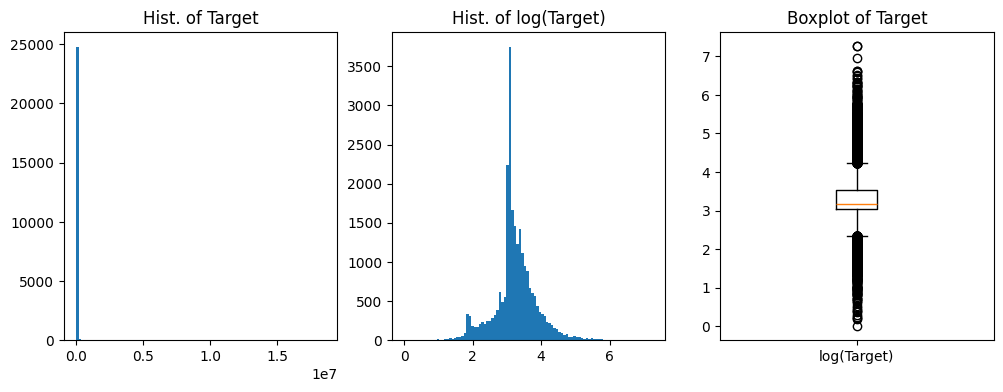

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

_ = axs[0].hist(df["target"], bins=100)
axs[0].set_title("Hist. of Target")
_ = axs[1].hist(df["target"].map(np.log10), bins=100)
axs[1].set_title("Hist. of log(Target)")
_ = axs[2].boxplot(df["target"].map(np.log10), labels=["log(Target)"])
axs[2].set_title("Boxplot of Target")

The plots indicate that the dependent variable, `target`, exhibits a very wide range and is highly skewed. Additionally, there are some data points with exceptionally high or low values, which may be considered outliers. However, we should be cautious about labeling a data point as an "outlier", since we are dealing with an insurance problem.

Could we investigate where these outliers come from? Since `target` is calculated by `SumClaimAmount` divided by `Exposure`, it is worth examining each of these variables.

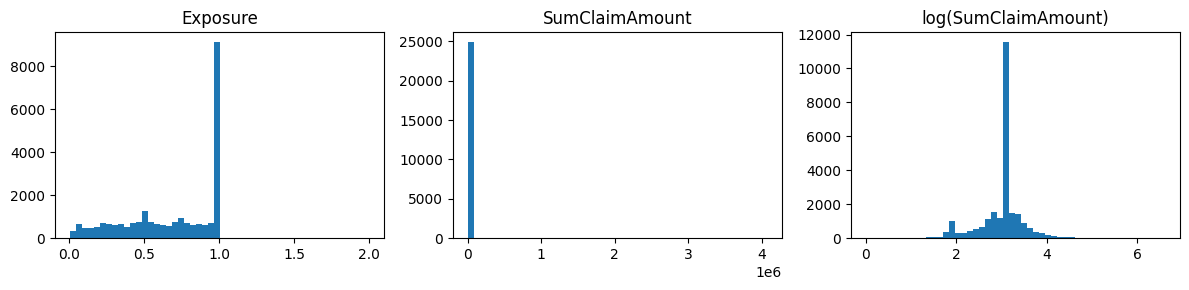

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
_ = axs[0].hist(df["Exposure"], bins=50)
axs[0].set_title("Exposure")
_ = axs[1].hist(df["SumClaimAmount"], bins=50)
axs[1].set_title("SumClaimAmount")
_ = axs[2].hist(df["SumClaimAmount"].map(np.log10), bins=50)
_ = axs[2].set_title("log(SumClaimAmount)")
plt.tight_layout()

The plots reveal instances in the dataset where `Exposure` values are very low, resulting in disproportionately high values for the dependent variable. However, considering the low likelihood of raising a claim, defining the dependent variable as `SumClaimAmount` divided by `Exposure` as a measure of the expected claim cost for each policyholder appears to overestimate the cost. This, in turn, leads to numerous high values, making the distribution of the dependent variable highly skewed.

On the other hand, there are cases with very high `SumClaimAmount`. Thus, removing instances that seem to be outliers requires careful consideration.

In [19]:
# df[df['Exposure']<0.01].shape
df[df["SumClaimAmount"] > 100000].shape

(42, 13)

As `target` has an enormous range and is skewed, we could also consider analyzing and using the log-transformed values of it.

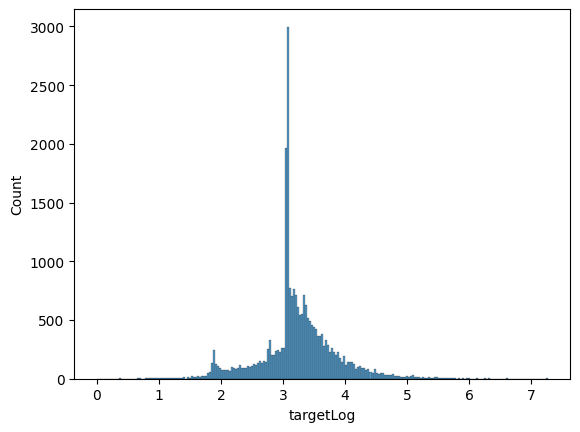

In [20]:
df["targetLog"] = df["target"].map(np.log10)
_ = sns.histplot(data=df, x="targetLog")

### Outliers
If we decide to remove outliers, we can use the IQR or Z-Score method. Here, the latter is used on the log values of the response variable.

In [21]:
# Z-Score
z_scores = stats.zscore(df["targetLog"])
threshold = 3
outliers = (z_scores < -threshold) | (z_scores > threshold)
df["IsOutlier"] = outliers

print(f"Number of outliers: {outliers.value_counts()[True]}")

# IRQ
# q1 = df['target'].quantile(0.25)
# q3 = df['target'].quantile(0.75)

# outliers = (df['target'] <= q1) | (df['target'] >= q3)
# print(f'Number of outliers: {outliers.value_counts()[True]}')

Number of outliers: 299


# Analysis of Numerical Variables

Focusing on contracts with claim costs, we analyze the numerical variables.

### VehPower

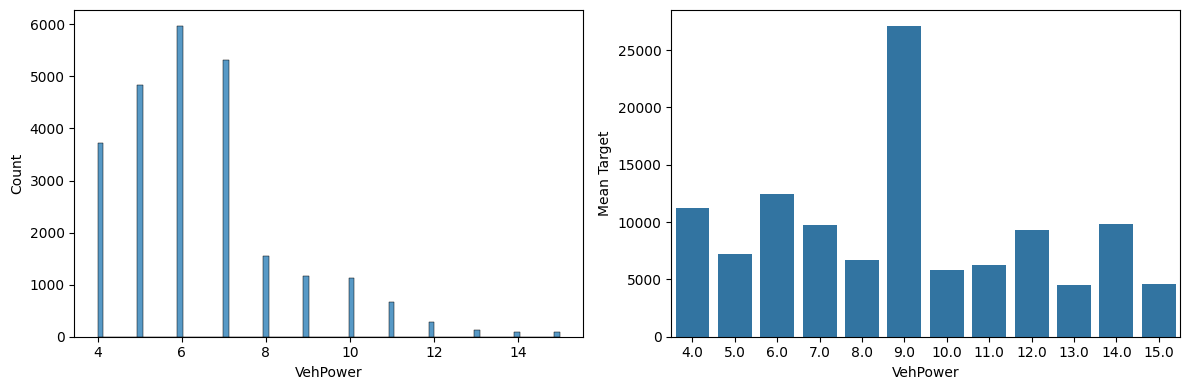

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
_ = sns.histplot(data=df, x="VehPower", ax=axs[0])
_ = sns.barplot(df, x="VehPower", y="target", errorbar=None, ax=axs[1])
axs[1].set_ylabel("Mean Target")
plt.tight_layout()
# df[df['VehPower']==9].nunique()

### VehAge 
     
Only 20 instances have `VehAge` > 30. These instances could be removed during modeling and treated differently later if necessary.

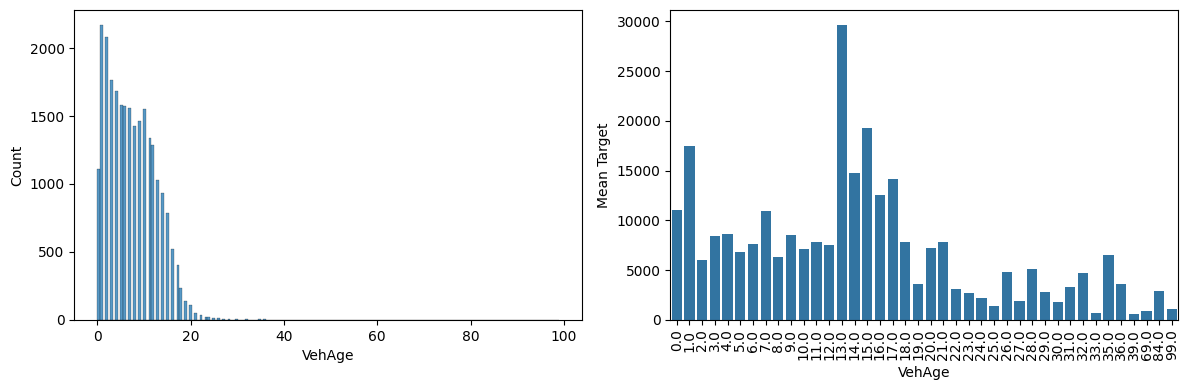

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
_ = sns.histplot(data=df, x="VehAge", ax=axs[0])
_ = sns.barplot(df, x="VehAge", y="target", errorbar=None, ax=axs[1])
axs[1].set_ylabel("Mean Target")
axs[1].tick_params(axis="x", rotation=90)
plt.tight_layout()

### DrivAge

Only 14 instances have `DrivAge` > 90.
These instances could be removed during modeling and treated differently later if necessary.

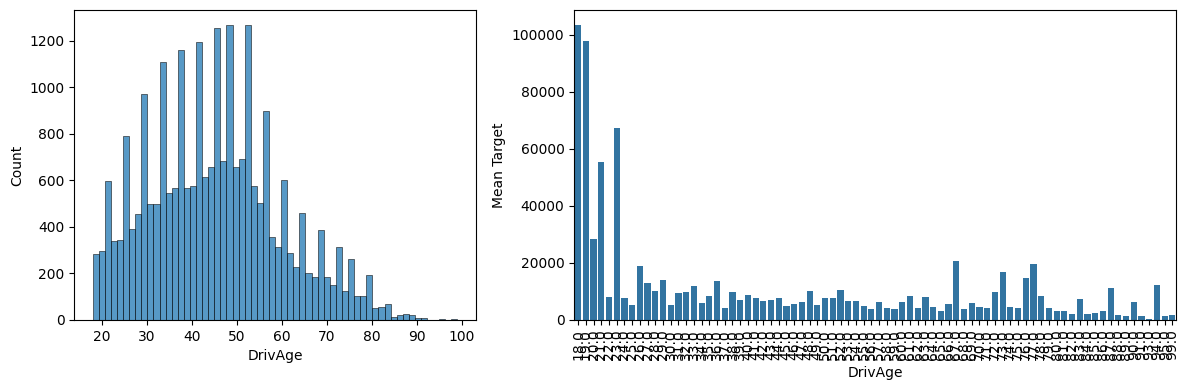

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), width_ratios=(1, 1.5))
_ = sns.histplot(data=df, x="DrivAge", ax=axs[0])
_ = sns.barplot(df, x="DrivAge", y="target", errorbar=None, ax=axs[1])
axs[1].set_ylabel("Mean Target")
axs[1].tick_params(axis="x", rotation=90)
plt.tight_layout()

### BonusMalus

Only 40 instances have `BonusMalus` > 150.
These instances could be removed during modeling and treated differently later if necessary.


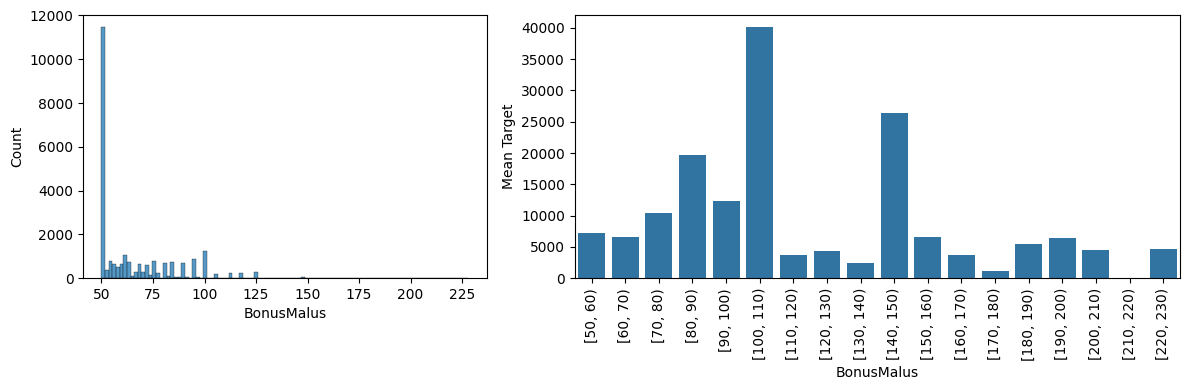

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), width_ratios=(1, 1.5))
bins = pd.cut(df["BonusMalus"], right=False, bins=range(50, 240, 10))
df_tmp = df.groupby(bins, observed=True)["target"].mean().to_frame().reset_index()
_ = sns.histplot(data=df, x="BonusMalus", ax=axs[0])
_ = sns.barplot(df_tmp, x="BonusMalus", y="target", errorbar=None, ax=axs[1])
axs[1].set_ylabel("Mean Target")
axs[1].tick_params(axis="x", rotation=90)
plt.tight_layout()

### Density 

We see a very wide range for this variable, and its distribution seems to follow a power law. So, we can also convert it into a log scale to resemble a normal distribution.

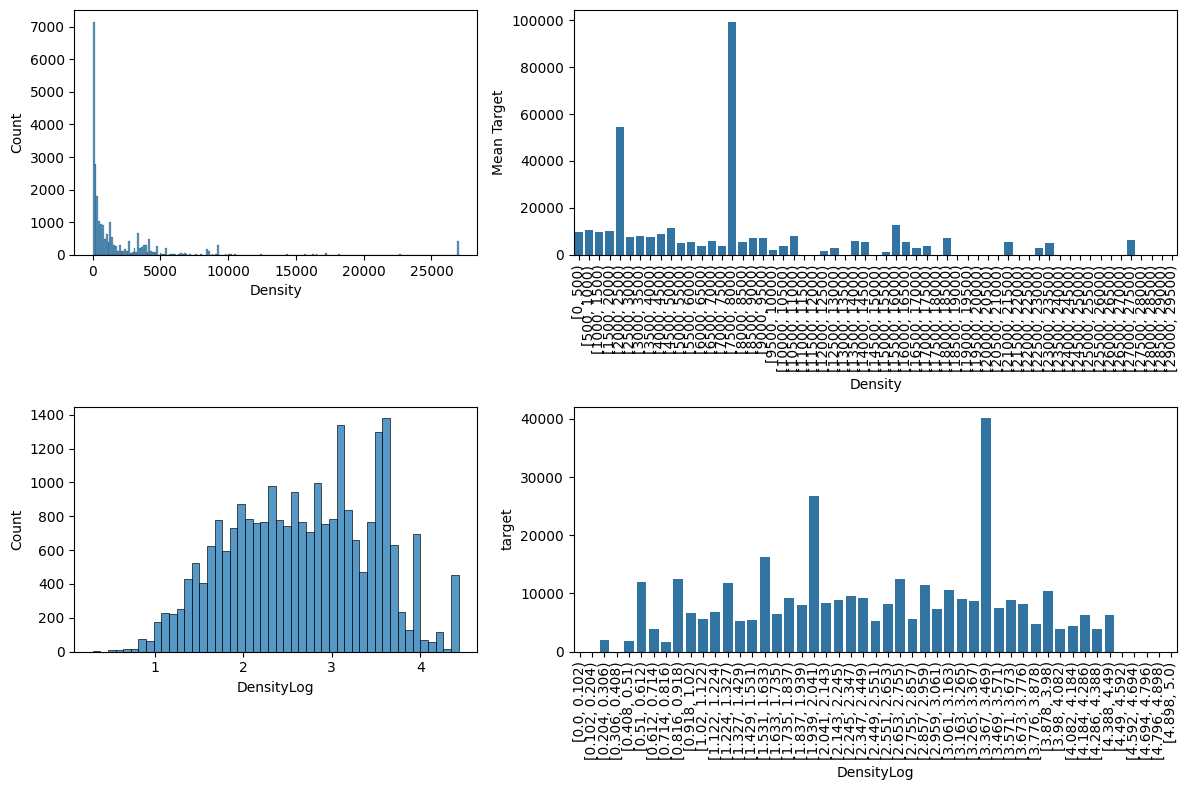

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), width_ratios=(1, 1.5))
axs = axs.flatten()
_ = sns.histplot(data=df, x="Density", ax=axs[0])

bins = pd.cut(df["Density"], right=False, bins=range(0, 30000, 500))
df_tmp = df.groupby(bins, observed=True)["target"].mean().to_frame().reset_index()
_ = sns.barplot(df_tmp, x="Density", y="target", errorbar=None, ax=axs[1])
axs[1].set_ylabel("Mean Target")
axs[1].tick_params(axis="x", rotation=90)

df["DensityLog"] = df["Density"].map(np.log10)
df_all["DensityLog"] = df_all["Density"].map(np.log10)

_ = sns.histplot(df["DensityLog"], ax=axs[2])

bins = pd.cut(df["DensityLog"], right=False, bins=np.linspace(0, 5, 50))
df_tmp = df.groupby(bins, observed=True)["target"].mean().to_frame().reset_index()
_ = sns.barplot(df_tmp, x="DensityLog", y="target", errorbar=None, ax=axs[3])
axs[3].tick_params(axis="x", rotation=90)

plt.tight_layout()

### Statistical Analysis of Numerical Variables

As shown in the plot below, the numerical variables exhibit very low correlation with both `target` and `targetLog`. Therefore, these features may not be highly effective in predicting the dependent variables.

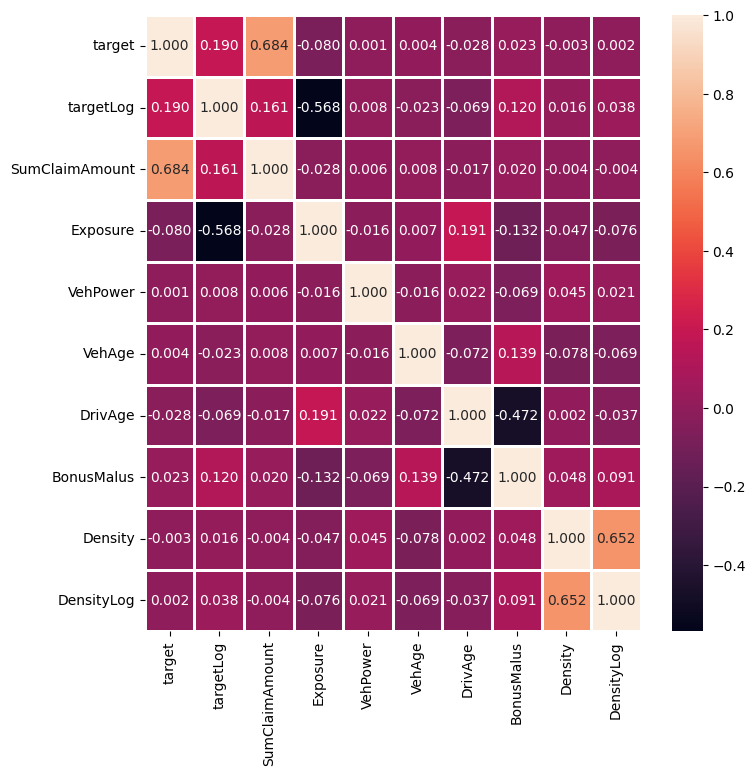

In [27]:
plt.figure(figsize=(8, 8))
cols = [
    "target",
    "targetLog",
    "SumClaimAmount",
    "Exposure",
    "VehPower",
    "VehAge",
    "DrivAge",
    "BonusMalus",
    "Density",
    "DensityLog",
]
_ = sns.heatmap(df[cols].corr(), annot=True, linewidths=1, fmt=".3f")

# Analysis of Categorical Variables

At this step, we analyze categorical variables.

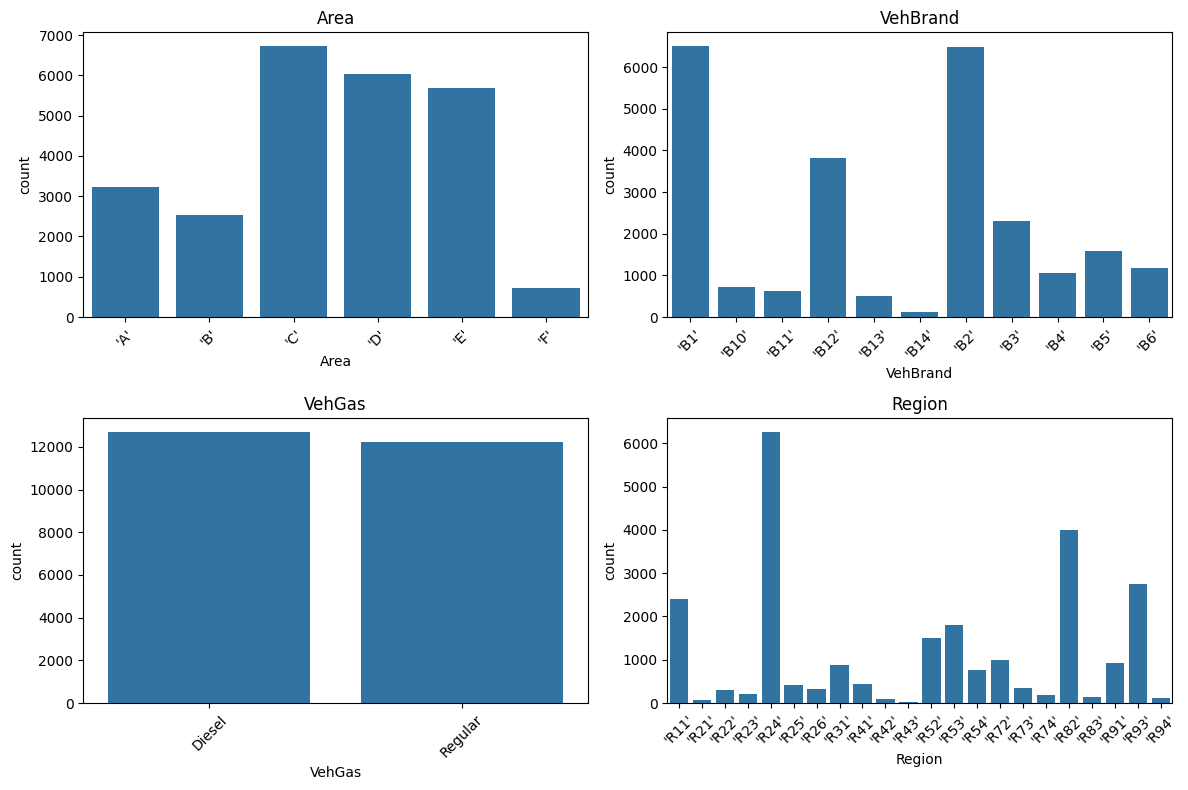

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()
for i, c in enumerate(cat_cols):
    sns.countplot(df, x=c, ax=axs[i])
    axs[i].tick_params(axis="x", rotation=45)
    axs[i].set_title(c)
plt.tight_layout()

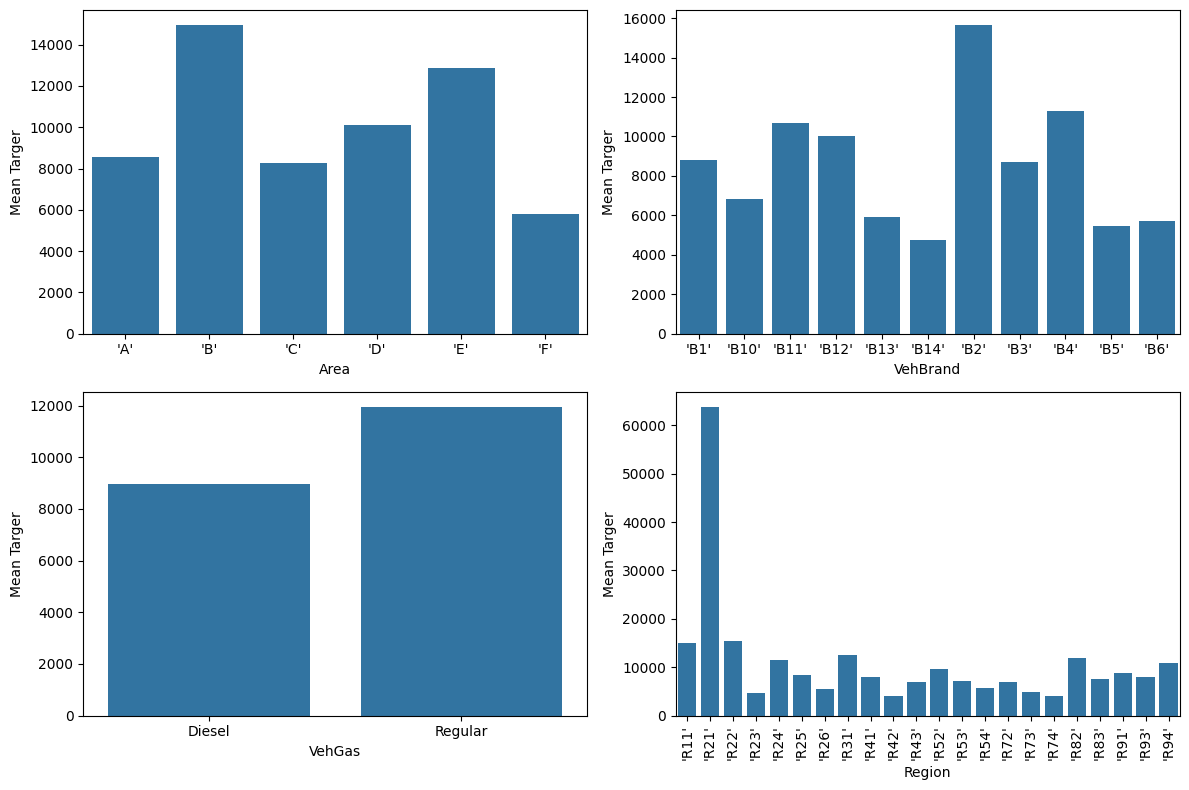

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()
for i, c in enumerate(cat_cols):
    sns.barplot(data=df, x=c, y="target", errorbar=None, ax=axs[i])
    axs[i].set_ylabel("Mean Targer")
axs[-1].tick_params(axis="x", rotation=90)
plt.tight_layout()

Similar to the numerical variables, these plots suggest that the dataset can be clustered into various groups, and each group can be treated differently.

One more question here: Is each region contained within a single area, so we could remove the `Area` column? NO

In [30]:
df.groupby(["Region"], observed=True)["Area"].nunique().to_frame().transpose()

Region,'R11','R21','R22','R23','R24','R25','R26','R31','R41','R42',...,'R53','R54','R72','R73','R74','R82','R83','R91','R93','R94'
Area,6,5,5,5,5,5,5,5,5,5,...,5,5,5,5,4,5,5,5,5,4


## Statistical Test of Categorical Variables

An ANOVA test is conducted on the categorical variables. The results indicate that the distribution of the `target` variable is not significantly different across all categorical variables. However, some categorical variables show a significant difference for `targetLog`. Therefore, it is expected that modeling `targetLog` will lead to better results.

In [31]:
def ANOVA_test(target_col):
    for c in cat_cols:
        df_tmp = [g[1] for g in df.groupby([c], observed=True)[target_col]]
        _, pvalue = stats.f_oneway(*df_tmp)
        print(f"Variable: {c}\tp-value: {pvalue}")


print("Dependent Variable: Target")
ANOVA_test("target")

print("\n\nDependent Variable: log(Target)")
ANOVA_test("targetLog")

Dependent Variable: Target
Variable: Area	p-value: 0.5621655789253363
Variable: VehBrand	p-value: 0.6401726096346133
Variable: VehGas	p-value: 0.22047970212461002
Variable: Region	p-value: 0.9735818647330804


Dependent Variable: log(Target)
Variable: Area	p-value: 2.864841485854489e-08
Variable: VehBrand	p-value: 3.6498732677036494e-60
Variable: VehGas	p-value: 0.8569818310183478
Variable: Region	p-value: 6.55718358261526e-36


# Regession

The statistical analysis of the features revealed that we do not have any fantastic features that can be used for predicting the dependent variable.

First, we attempt to predict the expected claim amount for a policyholder given he or she has a claim.

In [32]:
import xgboost as xgb
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


def get_SVR_model():
    preprocess = ColumnTransformer(
        transformers=[
            (
                "Cat",
                Pipeline(
                    [
                        ("OneHot", preprocessing.OneHotEncoder()),
                        ("Normalizer", preprocessing.StandardScaler(with_mean=False)),
                    ]
                ),
                cat_cols,
            ),
            ("Num-Normalizer", preprocessing.StandardScaler(), num_cols),
        ]
    )

    model = SVR()
    pipeline = Pipeline([("preprocess", preprocess), ("svr_model", model)])
    return pipeline


def get_XGB_model():
    preprocess = ColumnTransformer(
        [
            ("OrdinalEncoder", preprocessing.OrdinalEncoder(), cat_cols),
            ("Normalizer", preprocessing.StandardScaler(), num_cols),
        ]
    )

    model = xgb.XGBRegressor()
    pipeline = Pipeline([("preprocess", preprocess), ("xgb_model", model)])
    return pipeline


def get_RF_model():
    preprocess = ColumnTransformer(
        [
            ("OrdinalEncoder", preprocessing.OrdinalEncoder(), cat_cols),
            ("Normalizer", preprocessing.StandardScaler(), num_cols),
        ]
    )

    model = RandomForestRegressor()
    pipeline = Pipeline([("preprocess", preprocess), ("rf_model", model)])
    return pipeline


def get_test_train(df, cols, target):
    X = df[cols]
    y = df[target]
    return train_test_split(X, y, test_size=0.20, random_state=37)


def train(model):
    model.fit(train_x, train_y)

    pred_y = model.predict(test_x)
    mse = mean_squared_error(test_y, pred_y)

    return mse


def filter_dataset(df):
    df_tmp = df.copy()
    df_tmp = df_tmp[df_tmp["VehAge"] <= 30]
    df_tmp = df_tmp[df_tmp["DrivAge"] <= 90]
    df_tmp = df_tmp[df_tmp["BonusMalus"] <= 150]
    df_tmp = df_tmp[~df_tmp["IsOutlier"]]
    return df_tmp

In [33]:
num_cols = ["VehPower", "VehAge", "DrivAge", "BonusMalus", "DensityLog"]
cat_cols = ["Area", "VehBrand", "VehGas", "Region"]
cols = cat_cols + num_cols

df_tmp = filter_dataset(df)
target = "target"
train_x, test_x, train_y, test_y = get_test_train(df_tmp, cols, target)

mse = mean_squared_error(test_y, [train_y.mean()] * len(test_y))
print(f"Baseline - Root mean squared error (RMSE): {np.sqrt(mse):.2f}")

rf_model = get_RF_model()
mse = train(rf_model)
print(f"\nRandomForest - Root mean squared error (RMSE): {np.sqrt(mse):.2f}")

xgb_model = get_XGB_model()
mse = train(xgb_model)
print(f"\nXGB - Root mean squared error (RMSE): {np.sqrt(mse):.2f}")

svr_model = get_SVR_model()
mse = train(svr_model)
print(f"\nSVR - Root mean squared error (RMSE): {np.sqrt(mse):.2f}")

Baseline - Root mean squared error (RMSE): 9983.06

RandomForest - Root mean squared error (RMSE): 10498.55

XGB - Root mean squared error (RMSE): 10568.72

SVR - Root mean squared error (RMSE): 10333.84


In [34]:
target = "targetLog"
train_x, test_x, train_y, test_y = get_test_train(df, cols, target)

mse = mean_squared_error(test_y, [train_y.mean()] * len(test_y))
print(f"Baseline - Root mean squared error (RMSE): {np.power(10, np.sqrt(mse)):.2f}")

rf_model = get_RF_model()
mse = train(rf_model)
print(
    f"\nRandomForest - Root mean squared error (RMSE): {np.power(10, np.sqrt(mse)):.2f}"
)

xgb_model = get_XGB_model()
mse = train(xgb_model)
print(f"\nXGB - Root mean squared error (RMSE): {np.power(10, np.sqrt(mse)):.2f}")

svr_model = get_SVR_model()
mse = train(svr_model)
print(f"\nSVR - Root mean squared error (RMSE): {np.power(10, np.sqrt(mse)):.2f}")

Baseline - Root mean squared error (RMSE): 4.38

RandomForest - Root mean squared error (RMSE): 4.46

XGB - Root mean squared error (RMSE): 4.43

SVR - Root mean squared error (RMSE): 4.34


The above models did not perform satisfactorily. In fact, they performed worse than the baseline, which was simply the mean of the target variable. However, these results are not surprising given the outcomes of the statistical tests we observed previously.

We may attempt parameter optimization here. In this [post](https://medium.com/@mohsenim/tracking-machine-learning-experiments-with-mlflow-and-dockerizing-trained-models-germany-car-price-e539303b6f97) and [this](https://github.com/mohsenim/MLflow-XGBoost-Docker) GitHub repository, I have explained how to optimize hyperparameters for XGBoost, and the method can easily be generalized for other models as well. However, given the poor performance of the models with the default settings, I don't think parameter optimization will change anything here.

# Classification

We didn't get satisfactory results with regression. Now, I'm interested in investigating whether we can predict if a policyholder files a claim using the features. Thus, we convert the problem into a binary classification problem. 

We already know that in the dataset, only 3.7% of policyholders have filed a claim, while 96.3% have not. Such a highly imbalanced dataset requires careful handling of the imbalanced classes. For this classification task, I use logistic regression.

In [35]:
import torch
from torch.utils.data import DataLoader, TensorDataset


num_cols = ["VehPower", "VehAge", "DrivAge", "BonusMalus", "DensityLog"]
cat_cols = ["Area", "VehBrand", "VehGas", "Region"]

# Preprocess the data
preprocess = ColumnTransformer(
    transformers=[
        (
            "cat",
            Pipeline(
                [
                    ("OneHot", preprocessing.OneHotEncoder()),
                    (
                        "Normalizer",
                        preprocessing.StandardScaler(with_mean=False),
                    ),  
                ]
            ),
            cat_cols,
        ),
        ("num", preprocessing.StandardScaler(), num_cols),
    ]
)

target = "HasClaim"

# Split the data into training and test sets
X = df_all[num_cols + cat_cols]
y = df_all[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=37
)

X_train = preprocess.fit_transform(X_train).toarray()
X_test = preprocess.fit_transform(X_test).toarray()

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(list(y_train), dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(list(y_test), dtype=torch.float32)

# Create datasets
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [43]:
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))


def train_model(num_epochs, positive_class_weight=None):
    if positive_class_weight is not None:
        class_weights = compute_class_weight(
            "balanced", classes=np.unique(y_train), y=y_train
        )
        class_weight_tensor = torch.tensor(
            [positive_class_weight * class_weights[1]], dtype=torch.float32
        )

        # Define the loss function with class weight
        criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight_tensor)
    else:
        criterion = nn.BCEWithLogitsLoss()

    # Move the criterion to GPU if available
    model = LogisticRegression(X_train.shape[1]).to(device)
    criterion = criterion.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    print("Training ...")
    for epoch in range(num_epochs):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.unsqueeze(1))
            loss.backward()
            optimizer.step()
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item()}")

    return model


def evaluate(model):
    model.eval()
    y_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            predicted = (outputs.data > 0.5).float()
            y_pred += predicted.tolist()

    print(classification_report(y_test, y_pred, zero_division=0))

In [44]:
model = train_model(5, positive_class_weight=None)
print("")
evaluate(model)

Training ...
Epoch 5, Loss: 0.6931471824645996
Epoch 10, Loss: 0.6931471824645996

              precision    recall  f1-score   support

       False       0.96      1.00      0.98    130699
        True       0.00      0.00      0.00      4904

    accuracy                           0.96    135603
   macro avg       0.48      0.50      0.49    135603
weighted avg       0.93      0.96      0.95    135603



In [50]:
model = train_model(50, positive_class_weight=4)
evaluate(model)

Training ...
Epoch 5, Loss: 1.093119740486145
Epoch 10, Loss: 1.0352026224136353
Epoch 15, Loss: 1.1928868293762207
Epoch 20, Loss: 2.6955227851867676
Epoch 25, Loss: 1.1254448890686035
Epoch 30, Loss: 0.9496679306030273
Epoch 35, Loss: 0.9839045405387878
Epoch 40, Loss: 1.033744215965271
Epoch 45, Loss: 0.9856802225112915
Epoch 50, Loss: 1.0736278295516968
              precision    recall  f1-score   support

       False       0.98      0.42      0.58    130699
        True       0.05      0.73      0.08      4904

    accuracy                           0.43    135603
   macro avg       0.51      0.57      0.33    135603
weighted avg       0.94      0.43      0.56    135603



It seems that detecting policyholders who file a claim, i.e., recall, is more important than the accuracy or precision of the model. By using class weights and weighting the positive class (those instances with `HasClaim=True`), we can guide the model towards our desired outcome.

The insurance premium for each policyholder can initially be set based on the probability of filing a claim, with a safe margin included. Then, we use the classification model to adjust the premium: if the policyholder is classified as positive, we increase their premium proportionally based on the statistics of previously filed `ClaimAmount`s.

In the next step, we could go beyond the two positive and negative classes and cluster policyholders into groups. We can detect the cluster of each policyholder and adjust the insurance premium according to the statistics of previously filed `ClaimAmount`s in that cluster.